In [1]:
#Standard numerical analysis imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lhapdf
import pickle
import tqdm
import tensorflow as tf

#Import the ResNet-like model
from resnet_model import *

#Imports necessary for tensorflow model
from tensorflow.keras import models, optimizers, layers, losses, regularizers, callbacks

#Imports necessary for statistical analysis of model accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Import necessary to make the plotting look nice
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

#Makes the plotting font Times
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times"
})

# Confusion Matrix

In [2]:
#First build the x-axis
xs = build_xaxis()

#Create and split the PDF data into training and test sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data()

#Import the standard scaler model used to scale the training data
with open('flavor_scaler.pkl','rb') as f:
    sc = pickle.load(f)

#There are 6 classes for classification
num_classes = 6

#Input dimension
input_dim = 200

#Create, build, and load the pre-trained model's weights
class_model = PDFClassifier(input_dim, num_classes)
class_model.build(x_test.shape)
class_model.load_weights('pdf_ratio_classifier.hdf5')

 28/282 [=>............................] - ETA: 0s

2024-06-11 14:04:38.174373: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


282/282 [==============================] - 1s 4ms/step


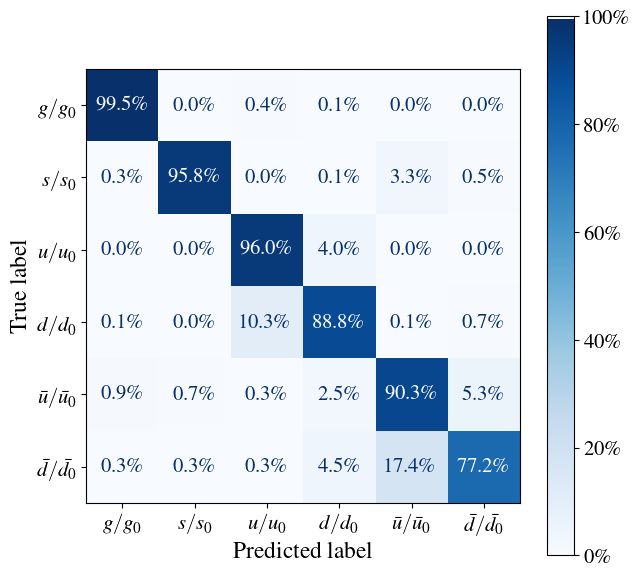

In [3]:
#Plotting the confusion matrix

#Set the size of the plot mat
fig, ax = plt.subplots(figsize=(7,7))

#Make classifier predictions on the withheld test set
preds = class_model.predict(x_test)

#Find the true/predicted class number from the onehot encodings
y_test_single = np.argmax(y_test,axis=1)
y_test_pred = np.argmax(preds,axis=1)

#Create a confusion matrix display from the predictions
disp = ConfusionMatrixDisplay.from_predictions(y_test_single,
                                               y_test_pred, 
                                               ax=ax,
                                               cmap='Blues',
                                               normalize='true',
                                               values_format='.1%')

#Sets the axis labels and fontsizes
ax.set_xlabel('Predicted label', fontsize=17)
ax.set_ylabel('True label', fontsize=17)

#Creates the colorbar that matches on the right side with particular values
#for the colorbar ticks
colorbar = ax.images[-1].colorbar
colorbar.ax.tick_params(labelsize=15)
colorbar.ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
colorbar.ax.set_yticklabels(['0\%', '20\%', '40\%', '60\%', '80\%', '100\%'])

#Changes the internal fonts of the confusion matrices to Times and puts a
#percentage sign after each one
for text in disp.text_.ravel():
    value = text.get_text() #get a particular text
    text.set_text(f'{float(value[:-1]):.1f}\%') #put percent sign
    text.set_fontsize(15)  # Change fontsize

#Establish text for particular class label numbers
# 0 = gluon, 1 = strange, 2 = u, 3 = d, 4 = ubar, 5 = dbar
x_labels = [r'$g/g_{0}$', 
            r'$s/s_{0}$', 
            r'$u/u_{0}$', 
            r'$d/d_{0}$', 
            r'$\bar{u}/\bar{u}_{0}$', 
            r'$\bar{d}/\bar{d}_{0}$']

#Make the text above into x and y labels
ax.set_xticklabels(x_labels)
ax.set_yticklabels(x_labels)

#Change fontsize
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#Save the figure as a PDF
plt.savefig('confusion_matrix_pdf_ratios.pdf', format='pdf')

#Show the figure
plt.show()

# Guided Backpropagation

In [4]:
#Preparation steps for guided backpropagation algorithm

#Create an array that contains all of the model layers that contain an activation
#Start after the input layer and end before the softmax layer
layer_dict = [layer for layer in class_model.model.layers[1:-1] if hasattr(layer,'activation')]

#Makes sure to change each layer in the model in case one of the activations has previously been changed
#This is necessary if you are going to run the guided backprop several times, or want to make predictions
#after you have performed guided backprop.
for layer in layer_dict:
    if ((layer.activation != tf.keras.activations.linear) & (layer.activation != tf.keras.activations.relu)):
        layer.activation = tf.keras.activations.relu

#Create a guided backpropagation model that takes in standard inputs as the trained model,
#but outputs not only the softmax score, but the input to the softmax layer as well 
#(dense output)
guidedbackprop_model = models.Model(
    inputs = [class_model.model.inputs],
    outputs = [class_model.model.get_layer('dense_output').output,
               class_model.model.get_layer('activation_softmax').output]
)

#Check and make sure that the model only contains linear, relu, and softmax layers at this point
for layer in guidedbackprop_model.layers:
    if hasattr(layer,'activation'):
        print(layer.activation)

<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function relu at 0x2d72b7e20>
<function linear at 0x2d72c89a0>
<function softmax at 0x2d713d580>


In [5]:
#Define the guided ReLU custom gradient, notice that you have 2 masks for the gradient
#The first mask is the deconvnet mask which sets the gradients that are negative equal to 0
#the second mask is the standard derivative of a ReLU function which masks which inputs were
#negative. Then you cast these masks as floats (turning them into 0s and 1s) and multiply
#by the gradient itself. 
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
    return tf.nn.relu(x), grad

#Create a guided backprop model layer array which finds all layers which have an activation function
#from the guided backprop model we created in the previous section. 
guidedbackprop_layer_dict = [layer for layer in guidedbackprop_model.layers[1:] if hasattr(layer,'activation')]

#Search for all layers which have a relu activation function and change it to a guidedReLU activation function
#which we just defined.
for layer in guidedbackprop_layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

#Check and see that all of the activations have been successfully changed in the guidedbackprop model
#The relu layers should now appear as custom gradient objects if successful.
for layer in guidedbackprop_model.layers:
    if hasattr(layer,'activation'):
        print(layer.activation)

<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function linear at 0x2d72c89a0>
<function softmax at 0x2d713d580>


In [6]:
#Set up an empty list to fill with gradients
grad_arr = []

#Iterate through the test set of PDFs that were not seen during training
for which_pdf in tqdm.tqdm(range(len(x_test))):
    #Convert and reshape the PDFs for inputs into the model
    input_data = tf.convert_to_tensor(x_test[which_pdf].reshape(1,200))
    #Convert the labels for the gradient process
    true_labels = tf.convert_to_tensor(y_test[which_pdf])

    #Create a gradient tape which watches operations for autodifferentiation in tensorflow
    with tf.GradientTape() as tape:

        #Tell the tape to watch this specific variable and all actions performed on it
        tape.watch(input_data)

        #Pass the input data through the guided backprop model and record the operations
        pre_softmax_result, post_softmax_result = guidedbackprop_model(input_data)

        #Calculate the particular output score that corresponds to the true label
        #of the classification.
        scores = pre_softmax_result[0][tf.argmax(true_labels)]

    #Take the gradient of the output score (presoftmax layer) with respect to the input PDF
    grads = tape.gradient(scores, input_data).numpy()

    #Normalize the gradients by setting everything nonzero and then dividing by the max
    norm_grads = np.maximum(grads,0)
    norm_grads = norm_grads / (norm_grads.max() + 1e-10)

    #Append the final gradients
    grad_arr.append(norm_grads)

#Make the gradient list an array for easy numerical operations later on
grad_arr = np.array(grad_arr)

100%|███████████████████████████████████████| 9000/9000 [01:32<00:00, 97.20it/s]


In [7]:
#Create the asymmetric error bands of the PDFs
def asymm_std(pdf_bundle, pdf_mean):

    #Define the positive and negative arrays
    pos_std = []
    neg_std = []

    #For each x in the bundle of PDFs
    for i in range(pdf_bundle.shape[1]):

        #Define the set of replicas
        replicas = pdf_bundle[:,i]
        
        #Decide if the particular PDF replica is greater than or less than 
        #the mean and assign them to the particular positive / negative array
        positives = replicas[replicas > pdf_mean[i]]
        negatives = replicas[replicas < pdf_mean[i]]

        #the value of the error band at that point is the standard deviation
        #of the set of replicas in positive and negative
        pos_std.append(np.std(positives))
        neg_std.append(np.std(negatives))
        
    return np.array(pos_std), np.array(neg_std)

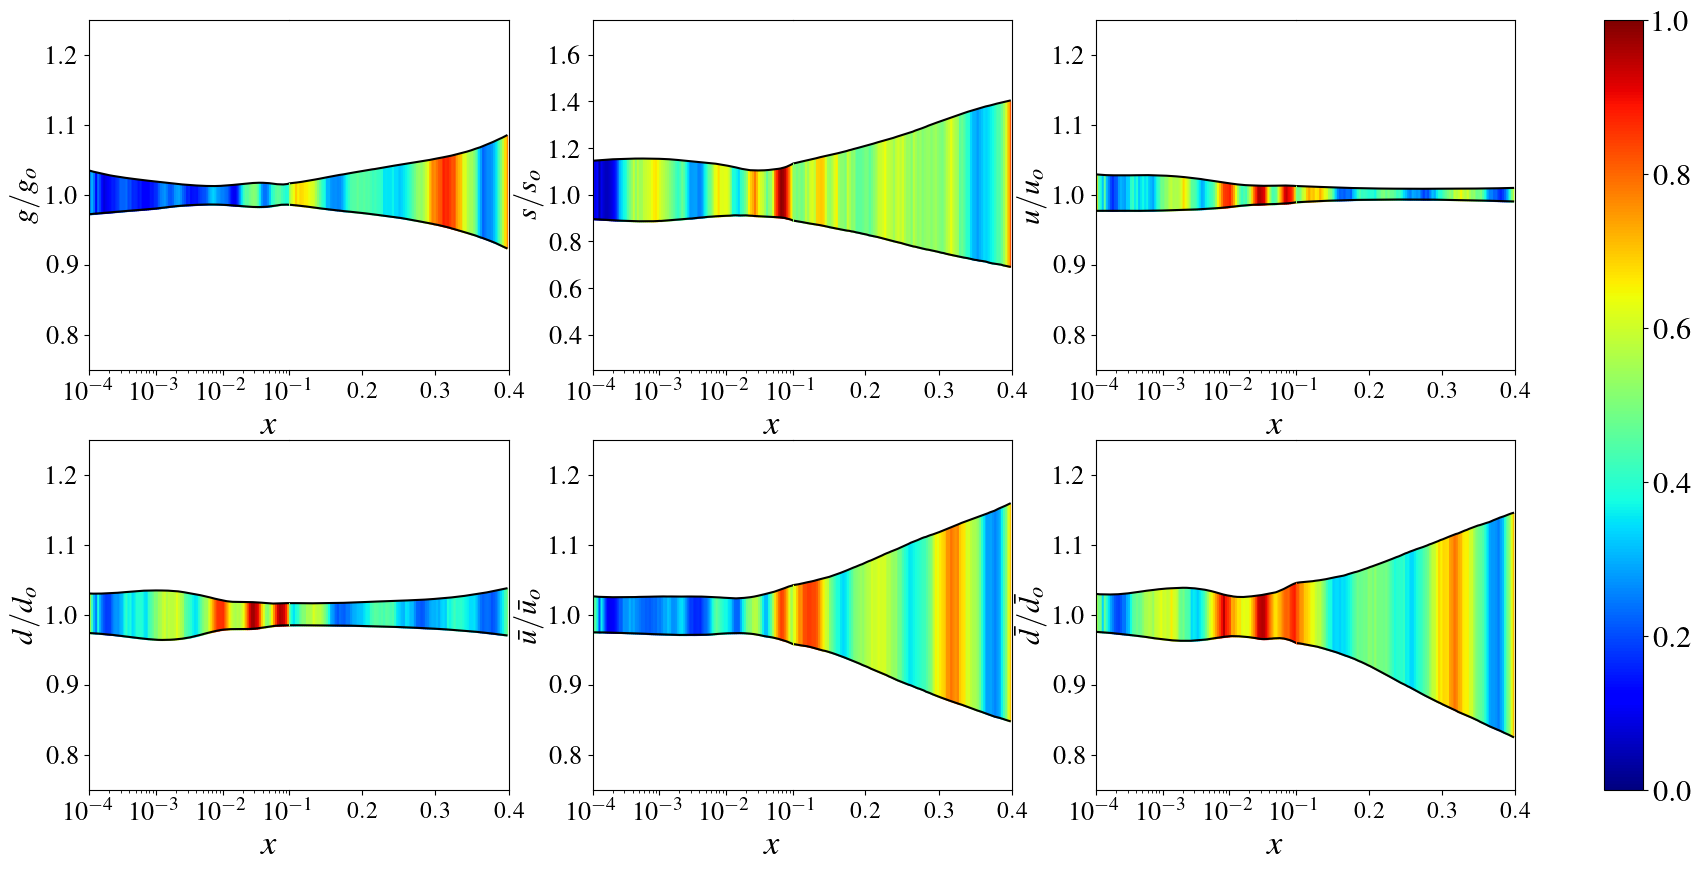

In [8]:
#We take the PDFs belonging to the test set and reshape and inverse
#transform the standard scaler model.
x_test_reshape = sc.inverse_transform(x_test)

#Setting up our plotting mat
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(23,10))

#Defining a moving average with a coarsity of 4
def moving_average(a, n=4):
    a = np.array(a)
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    to_ret = np.hstack([a[:n],ret[n-1:] / n])
    return to_ret

#Iterate through the PDF flavors as numbers 0-5
for pdf_flavor in range(6):

    #Bundle together all of the gradients and PDFs associated with each PDF flavor
    bundled_grads = grad_arr[np.argmax(y_test,axis=1) == pdf_flavor]
    bundled_pdfs = x_test_reshape[np.argmax(y_test,axis=1) == pdf_flavor]

    #Take the mean and the standard deviations of the gradients
    grad_std = bundled_grads.std(axis=0)[0]
    grad_mean = bundled_grads.mean(axis=0)[0]

    #Set mean and standard deviations between 0 and 1
    grad_std = grad_std/np.max(grad_std)
    grad_mean = grad_mean/np.max(grad_mean)

    #Smooth the gradient stds and means using the moving average function
    grad_std_smoothing = moving_average(grad_std,4)
    grad_mean_smoothing = moving_average(grad_mean,4)

    #define the mean and the asymmetrical PDF error bands 
    pdf_mean = bundled_pdfs.mean(axis=0)
    pos_std, neg_std = asymm_std(bundled_pdfs, pdf_mean)

    #Create the labels for the plotter
    ratio_labels = [r'$g/g_{o}$',r'$s/s_{o}$',r'$u/u_{o}$',
                    r'$d/d_{o}$',r'$\bar{u}/\bar{u}_{o}$',
                    r'$\bar{d}/\bar{d}_{o}$']

    #Plot on asymmetric x-axis
    axMain = plt.subplot(2,3,pdf_flavor+1)
    axMain.plot(xs,pdf_mean+pos_std,c='black')
    axMain.plot(xs,pdf_mean-neg_std,c='black')
    for i in range(len(xs)):
        #the fill color is defined as the standard deviation of the gradients
        axMain.fill_between(xs[i:i+2],
                         pdf_mean[i:i+2]+pos_std[i:i+2],
                         pdf_mean[i:i+2]-neg_std[i:i+2],
                         color=plt.cm.jet(grad_std_smoothing[i]))

    #Setting up the linear scale
    axMain.set_xscale('linear')
    axMain.set_xlim((0.101, 0.4))
    axMain.set_xticks([0.2,0.3,0.4])
    axMain.spines['left'].set_visible(False)
    axMain.yaxis.set_ticks_position('right')
    axMain.yaxis.set_visible(False)
    plt.xticks(fontsize=17)


    #Now do everything you just did but for the low-x logarithmic scale
    divider = make_axes_locatable(axMain)
    axLin = divider.append_axes("left", size=2.0, pad=0, sharey=axMain)
    axLin.set_xscale('log')
    axLin.set_xlim((1e-4, 0.1))
    axLin.plot(xs,pdf_mean+pos_std,c='black')
    axLin.plot(xs,pdf_mean-neg_std,c='black')
    for i in range(len(xs)):
        axLin.fill_between(xs[i:i+2],
                         pdf_mean[i:i+2]+pos_std[i:i+2],
                         pdf_mean[i:i+2]-neg_std[i:i+2],
                         color=plt.cm.jet(grad_std_smoothing[i]))
    axLin.spines['right'].set_visible(False)
    axLin.yaxis.set_ticks_position('left')
    plt.setp(axLin.get_xticklabels(), visible=True)

    #Different y limits for the strange PDF because it has bigger error bars
    if pdf_flavor == 1:
        plt.ylim(0.25,1.75)
    else:
        plt.ylim(0.75,1.25)

    #Set all the labels and ticks
    plt.ylabel(ratio_labels[pdf_flavor],fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    axMain.tick_params(axis='x', which='major', pad=5)
    axLin.tick_params(axis='x', which='major', pad=5)

    #Put the x-axis label, it needs to be defined this way because the x axis is split
    axMain.annotate(r'$x$', xy=(-0.1, -0.16), xycoords='axes fraction', fontsize=25, ha='center', va='center')

#Define the colorbar
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical')
cbar.ax.tick_params(labelsize=22)

#Save the figure as a PDF
plt.savefig('guidedbackprop_saliency_map.pdf', format='pdf')

#show the figure
plt.show()